In [7]:
import nomic
import json

#- Scientific programming
import numpy as np
import pandas as pd
from tqdm import tqdm
from graspologic.embed import ClassicalMDS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import balanced_accuracy_score as bas
from graspologic.embed import ClassicalMDS

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz

import math

## a function to check if a list contains only nan values
def contains_only_nan_or_zero(lst):
    for value in lst:
        if not math.isnan(value): ## if value is not nan 
            if not value == 0:
                return False
    return True


In [8]:
import pickle

# Specify the path to your .p file
file_path = "/Users/tianyichen/Desktop/Research /PhDresearch/Twitters/average_embeddings_by_cp.p"
file_path2 = "/Users/tianyichen/Desktop/Research /PhDresearch/Twitters/lora_embds.p"
# Open the file in binary mode
with open(file_path, "rb") as file:
    # Load the data from the file
    average_embeddings = pickle.load(file)

with open(file_path2, "rb") as file:
    # Load the data from the file
    lora_embeddings = pickle.load(file)
    


In [26]:
# there are 316 cps never post in 2024
# only seth_moulton never post pre 2024 but post in 2024 

In [6]:
lora_embeddings.keys()

dict_keys(['angus_king', 'ben_cardin', 'bernard_sanders', 'bill_cassidy', 'bill_hagerty', 'brian_schatz', 'catherine_masto', 'chuck_schumer', 'cindy_hyde-smith', 'cory_booker', 'cynthia_lummis', 'deb_fischer', 'debbie_stabenow', 'dianne_feinstein', 'dick_durbin', 'ed_markey', 'elizabeth_warren', 'gary_peters', 'jack_reed', 'jacky_rosen', 'james_lankford', 'jeanne_shaheen', 'jeff_merkley', 'jim_risch', 'john_barrasso', 'john_hickenlooper', 'john_hoeven', 'john_kennedy', 'john_thune', 'jon_ossoff', 'jon_tester', 'joseph_manchin', 'josh_hawley', 'kevin_cramer', 'maggie_hassan', 'maria_cantwell', 'mark_kelly', 'markwayne_mullin', 'michael_bennet', 'mike_braun', 'mike_lee', 'mitch_mcconnell', 'mitt_romney', 'pat_toomey', 'patrick_leahy', 'raphael_warnock', 'richard_blumenthal', 'richard_shelby', 'rick_scott', 'rob_portman', 'robert_casey', 'robert_menendez', 'roger_wicker', 'ron_johnson', 'sheldon_whitehouse', 'shelley_capito', 'sherrod_brown', 'susan_collins', 'tammy_baldwin', 'tammy_duckw

In [7]:
lora_embeddings['ben_cardin']

array([ 3.84944859, -0.50975705, -0.07390574])

In [9]:
lora_cp=[]
lora_array=[]

for cp in lora_embeddings.keys():
    if not contains_only_nan_or_zero(lora_embeddings[cp]) and cp in average_embeddings.keys():
        lora_cp.append(cp) ## they have to be nonzero in lora and appear in average_embeddings
        lora_array.append(lora_embeddings[cp])
lora_array = np.array(lora_array)
print(lora_array.shape)

(69, 3)


In [10]:
chosen_cp=[]
pre_2024_array=[]
post_2024_array=[]

for key in lora_cp:
    if not contains_only_nan_or_zero(average_embeddings[key]['pre-2024']) and not contains_only_nan_or_zero(average_embeddings[key]['post-2024']): 
        chosen_cp.append(key) # besides requierment above, we also require the cp to have both pre and post 2024 embeddings
        pre_2024_array.append(average_embeddings[key]['pre-2024'])
        post_2024_array.append(average_embeddings[key]['post-2024'])
        
pre_2024_array = np.array(pre_2024_array)
post_2024_array = np.array(post_2024_array)

cmds = ClassicalMDS(n_components=3)
pre_2024_CMDS = cmds.fit_transform(pre_2024_array)
post_2024_CMDS = cmds.fit_transform(post_2024_array)


print(post_2024_array.shape)

(51, 768)


In [11]:
#list(set(pre_2024_cp)-set(lora_cp))
list(set(lora_cp)-set(chosen_cp))
[lora_cp.index(cp) for cp in list(set(lora_cp)-set(chosen_cp))] ## we will delete these rows from array

[6, 58, 49, 23, 1, 43, 13, 7, 15, 47, 50, 44, 54, 10, 66, 14, 31, 41]

In [12]:
list(set(lora_cp)-set(chosen_cp))
lora_array_filtered = np.delete(lora_array, [lora_cp.index(cp) for cp in list(set(lora_cp)-set(chosen_cp))], axis=0)
lora_array_filtered.shape

(51, 3)

In [39]:
from scipy.spatial import procrustes
new_lora, new_avg_pre, test_stats_pre_2024= procrustes(lora_array_filtered, pre_2024_CMDS)
new_lora, new_avg_post, test_stats_post_2024= procrustes(lora_array_filtered, post_2024_CMDS)

print(test_stats_pre_2024,test_stats_post_2024)




0.662273500689833 0.7835703963611829


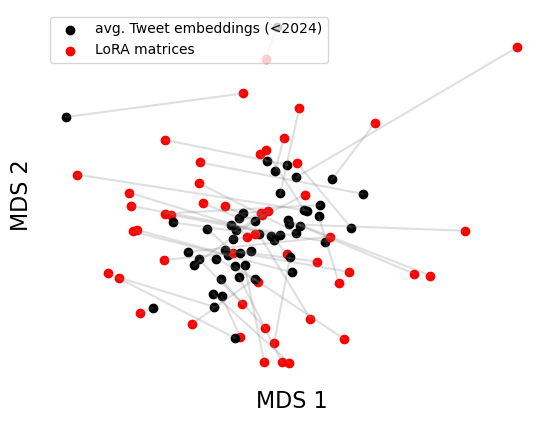

In [40]:
for cp in chosen_cp:
    ind = chosen_cp.index(cp)
    plt.scatter(new_avg_pre[ind,0], new_avg_pre[ind,1], c='black')
    #plt.scatter(new_avg_post[ind,0], new_avg_post[ind,1]  , c='black',marker='x')
    plt.scatter(new_lora[ind,0], new_lora[ind,1]  , c='red')
    plt.plot([new_avg_pre[ind,0], new_lora[ind,0]], [new_avg_pre[ind,1], new_lora[ind,1]], c='grey',alpha=0.25)
    #plt.plot([new_avg_post[ind,0], new_lora[ind,0]], [new_avg_post[ind,1], new_lora[ind,1]], '--' , c='grey',alpha=0.25)


    #plt.annotate(cp, (new_lora[ind,0], new_lora[ind,1]),size=10)
    #plt.annotate(cp, (new_avg[ind,0], new_avg[ind,1]),size=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([]) 
ax.set_yticks([])
ax.set_ylabel("MDS 2", fontsize=16)
ax.set_xlabel("MDS 1", fontsize=16)

ax.legend(['avg. Tweet embeddings (<2024)' ,'LoRA matrices'], loc='upper left')

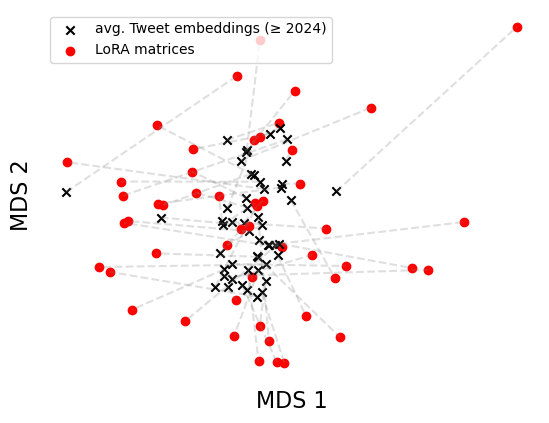

In [41]:
for cp in chosen_cp:
    ind = chosen_cp.index(cp)
    #plt.scatter(new_avg_pre[ind,0], new_avg_pre[ind,1], c='black')
    plt.scatter(new_avg_post[ind,0], new_avg_post[ind,1]  , c='black',marker='x')
    plt.scatter(new_lora[ind,0], new_lora[ind,1]  , c='red')
    #plt.plot([new_avg_pre[ind,0], new_lora[ind,0]], [new_avg_pre[ind,1], new_lora[ind,1]], c='grey',alpha=0.25)
    plt.plot([new_avg_post[ind,0], new_lora[ind,0]], [new_avg_post[ind,1], new_lora[ind,1]], '--' , c='grey',alpha=0.25)


    #plt.annotate(cp, (new_lora[ind,0], new_lora[ind,1]),size=10)
    #plt.annotate(cp, (new_avg[ind,0], new_avg[ind,1]),size=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([]) 
ax.set_yticks([])
ax.set_ylabel("MDS 2", fontsize=16)
ax.set_xlabel("MDS 1", fontsize=16)

ax.legend(['avg. Tweet embeddings (\u2265 2024)', 'LoRA matrices'], loc='upper left')


In [42]:
L2_pre=[]
L2_post=[]
Btimes=50000

for i in range(Btimes):
    avg_permuted_pre = np.random.permutation(pre_2024_CMDS)
    avg_permuted_post = np.random.permutation(post_2024_CMDS)
    new_lora, new_avg_pre, dis1= procrustes(lora_array_filtered, avg_permuted_pre)
    new_lora, new_avg_post, dis2= procrustes(lora_array_filtered, avg_permuted_post)
    L2_pre.append(dis1)
    L2_post.append(dis2)

In [43]:
p_pre=sum(L2_pre<test_stats_pre_2024)/Btimes
p_post=sum(L2_post<test_stats_post_2024)/Btimes

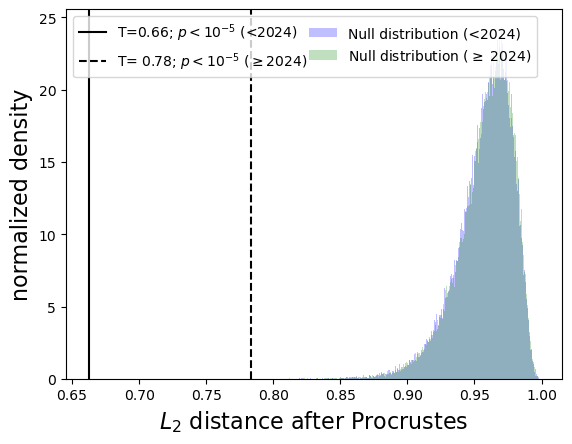

In [44]:
# Plot the histograms
#plt.axvline(x=test_stats_pre_2024, color='black',c='k', label=f'T={test_stats_pre_2024:1.2f}; $p$<{1/Btimes:1.2f} (<2024)')
#plt.axvline(x=test_stats_post_2024, color='black',c='k', linestyle='--',label=f'T={test_stats_post_2024: 1.2f}; $p$<{1/Btimes:1.2f} ($\geq$2024)')

plt.axvline(x=test_stats_pre_2024, color='black',c='k', label=f'T={test_stats_pre_2024:1.2f}; $p<10^{{-5}}$ (<2024)')
plt.axvline(x=test_stats_post_2024, color='black',c='k', linestyle='--',label=f'T={test_stats_post_2024: 1.2f}; $p<10^{{-5}}$ ($\geq$2024)')

plt.hist(L2_pre, bins=300, color='blue', alpha=0.25, label='Null distribution (<2024)',density=True)
plt.hist(L2_post, bins=300, color='green', alpha=0.25, label='Null distribution ($\geq$ 2024)',density=True)




ax = plt.gca()
ax.legend(ncol=2, loc='upper left', columnspacing=0.1)
ax.set_ylabel("normalized density", fontsize=16)
ax.set_xlabel('$L_2$ distance after Procrustes', fontsize=16)
# Show the figure
plt.show()




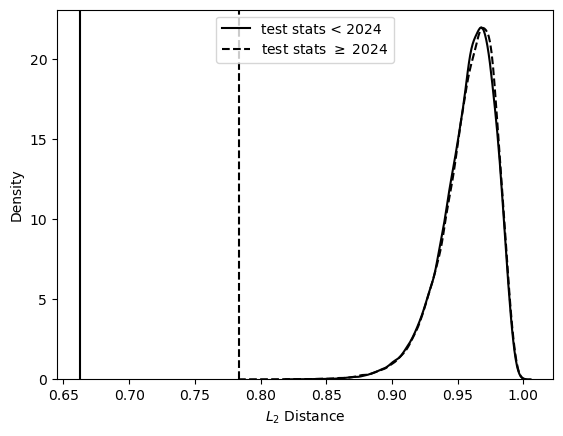

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot density of L2_pre and L2_post
sns.kdeplot(data=L2_pre,color='black')
sns.kdeplot(data=L2_post, linestyle='--', color='black')

# Add vertical lines for test_stats_pre_2024 and test_stats_post_2024
plt.axvline(x=test_stats_pre_2024, color='black', label='test stats < 2024')
plt.axvline(x=test_stats_post_2024, color='black', linestyle='--', label='test stats $\geq$ 2024')

# Set plot title and labels
plt.xlabel('$L_2$ Distance')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show the plot
plt.show()


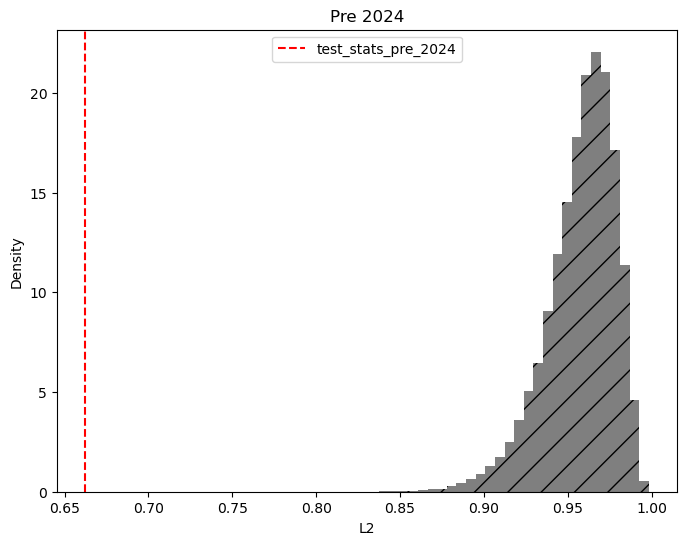

In [34]:
import matplotlib.pyplot as plt

# Plot the density of L2
plt.figure(figsize=(8, 6))
plt.hist(L2_pre, density=True, bins=30, alpha=0.5,hatch='/',color='black')
plt.xlabel('L2')
plt.ylabel('Density')
plt.title('Pre 2024' )

# Add a vertical line at test_stats_pre_2024
plt.axvline(x=test_stats_pre_2024, color='red', linestyle='--', label='test_stats_pre_2024')
plt.legend()

# Show the plot
plt.show()


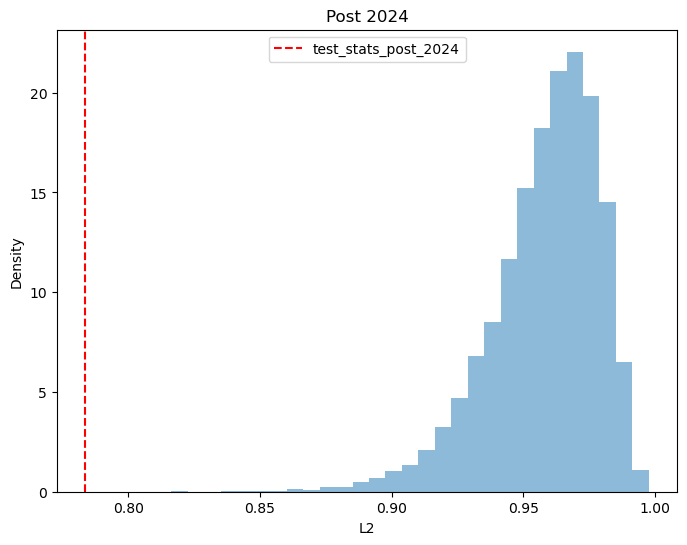

In [248]:
import matplotlib.pyplot as plt

# Plot the density of L2
plt.figure(figsize=(8, 6))
plt.hist(L2_post, density=True, bins=30, alpha=0.5)
plt.xlabel('L2')
plt.ylabel('Density')
plt.title('Post 2024' )

plt.axvline(x=test_stats_post_2024, color='red', linestyle='--', label='test_stats_post_2024')
plt.legend()

# Show the plot
plt.show()

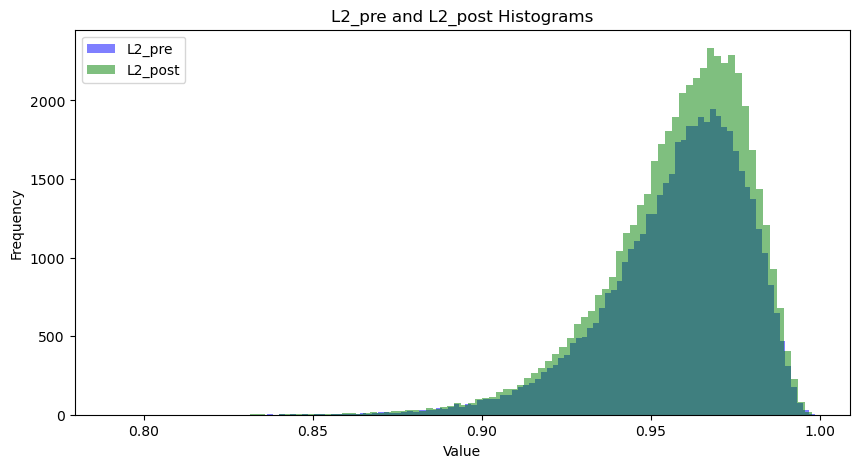

In [60]:
import matplotlib.pyplot as plt

# Create a new cell and execute the following code
plt.figure(figsize=(10, 5))

# Plot the histograms
plt.hist(L2_pre, bins=100, color='blue', alpha=0.5, label='L2_pre')
plt.hist(L2_post, bins=100, color='green', alpha=0.5, label='L2_post')

# Add labels and title
plt.title('L2_pre and L2_post Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show the figure
plt.show()


In [174]:
#lora_embeddings['tammy_baldwin']
#average_embeddings['tammy_baldwin']['pre-2024']

In [121]:
cp='tammy_baldwin'
pre_2024_array[pre_2024_cp.index(cp)]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.